In [4]:
%matplotlib inline
import cv2
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from tensorflow.keras import layers, regularizers
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import time
import os

In [5]:
def get_all_imgs(path):
    # Read all pictures in the current directory
    imgs = []
    imgs_data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if os.path.splitext(file)[1] == '.png':
                img = os.path.join(root, file)
                imgs.append(img)
                imgs_data.append(cv2.imread(img))
    return imgs_data

In [11]:
def show(image):
    # Figure size in inches
    plt.figure(figsize=(15, 15))
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Show image, with nearest neighbour interpolation
    plt.imshow(image, interpolation='nearest')
    
def show_hsv(hsv):
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    show(rgb)
    
def show_mask(mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
    
def overlay_mask(mask, image):
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    show(img)
    
def uni(arr):
    unique_arr, counts_arr = np.unique(arr, return_counts=True)
    print(arr.shape, unique_arr, counts_arr)

In [ ]:
imgs=get_all_imgs('../00_data/04_1-250')

In [ ]:
rips=get_all_imgs('../00_data/02_instance+ripeness_segmentation')

In [15]:
#load images and segmentation maps
images = get_all_imgs('../00_data/04_1-250')
segmentations = get_all_imgs('../00_data/03_instance_segmentation_1-250/')

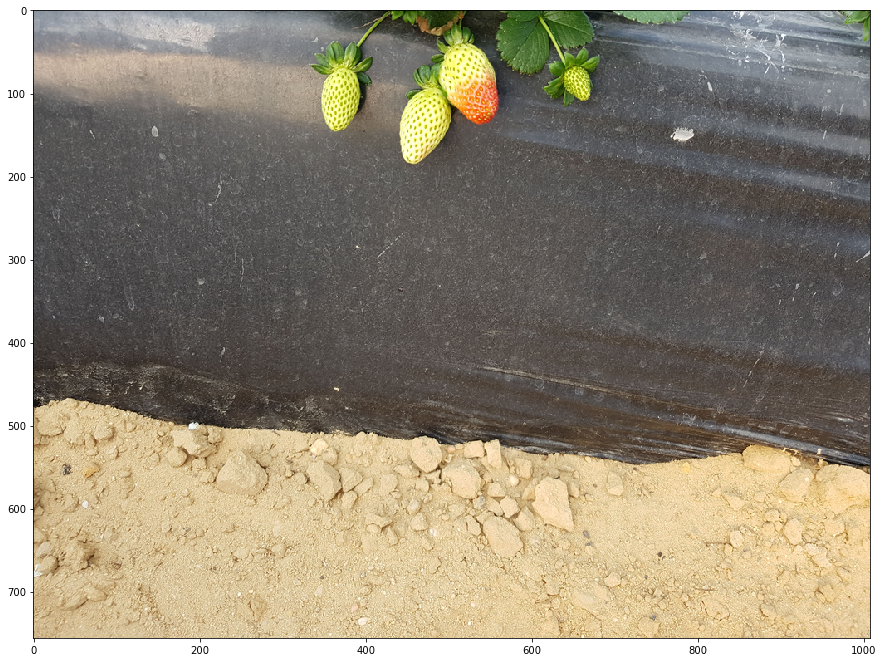

In [17]:
show(images[0])

In [18]:
#preprocess images and segmentations
X = []
y = []
for img, seg in zip(images, segmentations):
    #resize images to a fixed size
    img = cv2.resize(img, (200, 200))
    seg = cv2.resize(seg, (200, 200))
    #convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    seg = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)
    #flatten images to vectors
    img = img.flatten()
    seg = seg.flatten()
    X.append(img)
    y.append(seg)

#convert to numpy array
X = np.array(X)
y = np.array(y)

In [34]:
X[0]

array([143, 143, 145, ..., 199, 189, 227], dtype=uint8)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=40000))
model.add(Dense(128, activation='relu'))
model.add(Dense(40000, activation='sigmoid'))

Epoch 1/10
6/6 [==============================] - 4s 288ms/step - loss: 1.6970 - accuracy: 0.0000e+00 - val_loss: 0.6610 - val_accuracy: 0.0000e+00
Epoch 2/10
6/6 [==============================] - 1s 195ms/step - loss: 0.9514 - accuracy: 0.0000e+00 - val_loss: 0.6601 - val_accuracy: 0.0000e+00
Epoch 3/10
6/6 [==============================] - 1s 202ms/step - loss: 0.6708 - accuracy: 0.0000e+00 - val_loss: 0.6735 - val_accuracy: 0.0000e+00
Epoch 4/10
6/6 [==============================] - 1s 204ms/step - loss: 0.6499 - accuracy: 0.0000e+00 - val_loss: 0.6420 - val_accuracy: 0.0000e+00
Epoch 5/10
6/6 [==============================] - 1s 211ms/step - loss: 0.6562 - accuracy: 0.0000e+00 - val_loss: 0.6556 - val_accuracy: 0.0000e+00
Epoch 6/10
6/6 [==============================] - 1s 193ms/step - loss: 0.7199 - accuracy: 0.0000e+00 - val_loss: 0.6539 - val_accuracy: 0.0000e+00
Epoch 7/10
6/6 [==============================] - 1s 197ms/step - loss: 0.6526 - accuracy: 0.0000e+00 - val_loss

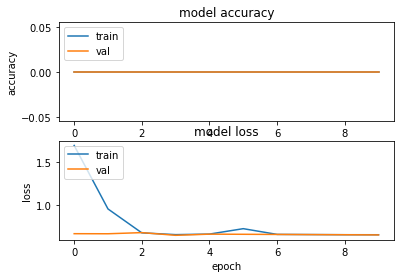

In [33]:
#compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=32, validation_data=(X_test, y_test))
end = time.time()
print('Running time = {} min {} s'.format(int((end - start) / 60), int((end - start) % 60)))

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:

#save model
model.save('strawberry_segmentation.h5')

In [23]:
def config(img):
    #resize image to a fixed size
    img = cv2.resize(img, (200, 200))

    #convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #flatten image to vector
    img = img.flatten()

    #convert to numpy array
    img = np.array([img])
    
    return img

In [29]:
#load pre-trained model
from keras.models import load_model
model = load_model('strawberry_segmentation.h5')

#load image
img = cv2.imread('test.png')

img_ = config(img)

#predict segmentation map
seg_map = model.predict(img_)

1/1 [==============================] - 0s 180ms/step


In [30]:
seg_map.shape

(1, 40000)

In [31]:
#get bounding boxes
bounding_boxes = []
for i in range(seg_map.shape[0]):
    for j in range(seg_map.shape[1]):
        if seg_map[i][j] > 0.9:
            #assume threshold at 0.9
            x1 = i - 10
            y1 = j - 10
            x2 = i + 10
            y2 = j + 10
            bounding_boxes.append([x1, y1, x2, y2])

#draw bounding boxes
for box in bounding_boxes:
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

#save image
cv2.imwrite('result.png', img)
cv2.waitKey(0)

-1

In [35]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = '8_ori.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n07745940', 'strawberry', 0.9955642), ('n07753275', 'pineapple', 0.0019742697), ('n07753592', 'banana', 0.00087258144)]


In [50]:
pip install git+https://github.com/tensorflow/models.git#subdirectory=research/object_detection

^C
Note: you may need to restart the kernel to use updated packages.


In [49]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.ssd import SSD300
from tensorflow.keras.applications.ssd import preprocess_input as ssd_preprocess_input
from tensorflow.keras.applications.ssd import decode_predictions
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

img_path = '8_ori.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

ssd_model = SSD300(weights='imagenet', include_top=False)
ssd_input = ssd_preprocess_input(features)

predictions = ssd_model.predict(ssd_input)
results = decode_predictions(predictions, top=2)[0]

for result in results:
    if result[1] == 'strawberry':
        bbox = result[2]
        print('Bounding box for strawberry: ', bbox)

ModuleNotFoundError: No module named 'tensorflow.keras.applications.ssd'

In [48]:
pip install keras-layers

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement keras-layers (from versions: none)
ERROR: No matching distribution found for keras-layers


In [39]:
len(features[0])

7

In [42]:
features[0][1].shape

(7, 512)